In [1]:
import cv2
import os
import numpy as np
from keras.utils import to_categorical
from PIL import Image
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D , Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,  recall_score, f1_score

## Importing libraries and reading dataset

In [2]:
data_path = 'datasets/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'no': 0, 'yes': 1}
['no', 'yes']
[0, 1]


## Resizing and converting images into greyscale

In [3]:
img_size = 224
data = []
label = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            # resizing the image into 224x224, as required by ResNet50
            data.append(resized)
            label.append(label_dict[category])
            # appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:', e)
            # if any exception raised, the exception will be printed here. And pass to the next image

In [4]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)
# new_label = to_categorical(label)

In [5]:
data.shape

(3000, 224, 224, 3)

## Splitting dataset into testing and training

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

## Plotting sample of images

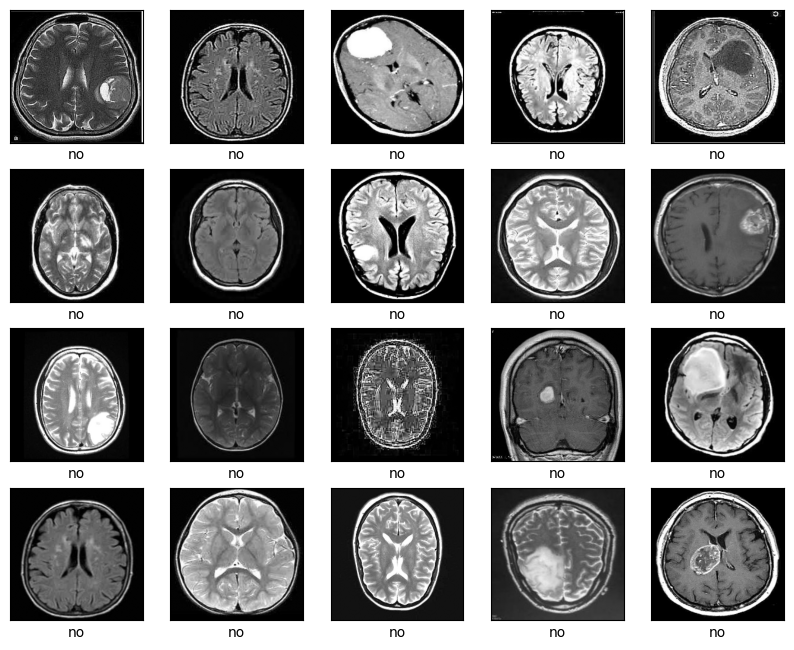

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

## ResNET50

In [8]:
input_size = 224
resnet_model = Sequential()
base_resnetmodel = tf.keras.applications.ResNet50(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')

for layer in base_resnetmodel.layers:
    layer.trainable = False
# resnet_model.add(pretrained_resnetmodel)
# Create the model architecture
x = base_resnetmodel.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_resnetmodel.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [9]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("res50_model.h5", monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train, 
                        batch_size=32,
                        epochs=10, 
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, checkpoint])

Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.6286

C:\Users\mohdh\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 108s 2s/step - loss: 0.8399 - accuracy: 0.6286 - val_loss: 0.5763 - val_accuracy: 0.6708
Epoch 2/10
60/60 [==============================] - 112s 2s/step - loss: 0.5998 - accuracy: 0.6693 - val_loss: 0.5427 - val_accuracy: 0.7479
Epoch 3/10
60/60 [==============================] - 116s 2s/step - loss: 0.5343 - accuracy: 0.7010 - val_loss: 0.4980 - val_accuracy: 0.7354
Epoch 4/10
60/60 [==============================] - 116s 2s/step - loss: 0.5053 - accuracy: 0.7245 - val_loss: 0.4302 - val_accuracy: 0.7979
Epoch 5/10
60/60 [==============================] - 118s 2s/step - loss: 0.4633 - accuracy: 0.7677 - val_loss: 0.4554 - val_accuracy: 0.7958
Epoch 6/10
60/60 [==============================] - 114s 2s/step - loss: 0.4822 - accuracy: 0.7547 - val_loss: 0.4036 - val_accuracy: 0.8042
Epoch 7/10
60/60 [==============================] - 116s 2s/step - loss: 0.4413 - accuracy: 0.7714 - val_loss: 0.5477 - val_accuracy: 0.7146
Epoch 8/10
60/60 [======

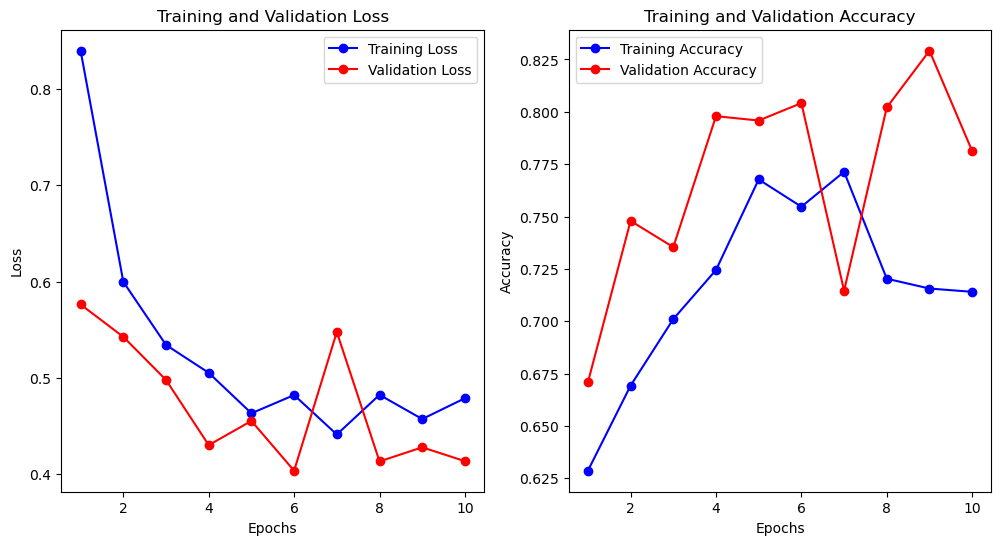

In [12]:
# Learning Curve
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1) 
train_predictions = (model.predict(x_train) > 0.5).astype("int32").flatten()
val_predictions = (model.predict(x_val) > 0.5).astype("int32").flatten()
test_predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()

19/19 [==============================] - 30s 1s/step


In [15]:
train_f1 = f1_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_accuracy = accuracy_score(y_train, train_predictions)

val_f1 = f1_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions)
val_recall = recall_score(y_val, val_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

test_f1 = f1_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

In [16]:
# Print results
# print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

# Print validation metrics
print("\nValidation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)

# Print test metrics
print("\nTest Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Training Accuracy: 0.8114583333333333
Training F1 Score: 0.8357531760435571
Training Precision: 0.7524509803921569
Training Recall: 0.939795918367347

Validation Accuracy: 0.78125
Validation F1 Score: 0.8
Validation Precision: 0.7191780821917808
Validation Recall: 0.9012875536480687

Test Accuracy: 0.8066666666666666
Test F1 Score: 0.823170731707317
Test Precision: 0.7317073170731707
Test Recall: 0.9407665505226481


In [20]:
y_pred = model.predict(x_test)
# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

19/19 [==============================] - 22s 1s/step


In [21]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[214  99]
 [ 17 270]]


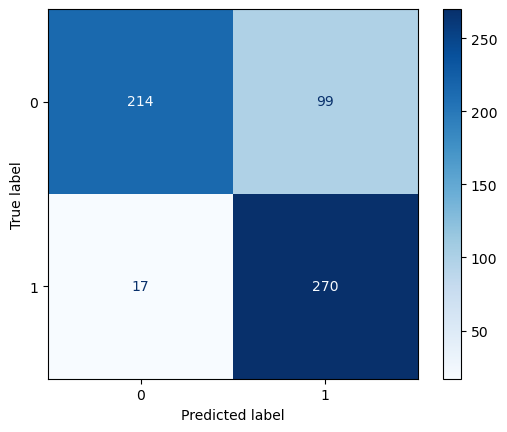

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [25]:
from keras.models import load_model
model_loaded = load_model('res50_model.h5')

In [29]:
# Load and preprocess the new image
image_folder = 'datasets/no'
image_name = 'no20.jpg'
image_path = os.path.join(image_folder, image_name)

new_image = cv2.imread(image_path)
new_image = cv2.resize(new_image, (224, 224))  # Resize to match the input size of your model
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
new_image = new_image.astype(np.float32) / 255.0  # Normalize pixel values

new_image = np.expand_dims(new_image, axis=0)

# Make predictions
prediction = model.predict(new_image)

# Interpret the prediction
if prediction[0, 0] > 0.5:
    print('The model predicts that the image contains a tumor.')
else:
    print('The model predicts that the image does not contain a tumor.')

1/1 [==============================] - 0s 72ms/step
The model predicts that the image does not contain a tumor.
